In [1]:
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from glob import glob

class VisDroneDataset(Dataset):
    """ VisDrone dataset."""

    def __init__(self, csv_files, root_dir, transform=None):
        """
        Args:
            csv_files (list of strings): Path to the csv file with annotations.
            root_dir (string): Directory containing annotations and images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        header_names =  ["frame_index","target_id","bbox_left","bbox_top","bbox_width","bbox_height","score","object_category","truncation", "occlusion"]
        self.frames_objects = dict()
        self.seq_range=dict()
        curr = 0
        for csv_file in csv_files:
            seq_name = csv_file.split("/")[-1].split(".")[0]
            df = pd.read_csv(csv_file, header=None, names=header_names)
            seq_len = max(df['frame_index'])
            self.seq_range[seq_name] = range(curr, curr + seq_len)
            curr += seq_len
            self.frames_objects[seq_name] = df
        self.num_frames = curr
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.num_frames

    def index2file(self, index):
        seq = ""
        for s in self.seq_range.keys():
            if index in self.seq_range[s]:
                seq = s
                break
        frame = index - self.seq_range[s][0] + 1
        return seq, frame

    def __getitem__(self, idx):
        '''
        Args:
            idx (int):  unique id of the frame
        returns:
            tuple:
                0: image (PIL Image): ndarray of frame image
                1: target (dict):
                    image_id (Int64Tensor[1]): unique identifier of the image. = idx
                    frame_id (Int64Tensor[1]): frame number of the image in the video.

                    boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in ["bbox_left","bbox_top","bbox_width","bbox_height"].
                    class_id (Int64Tensor[N]): the class of the bounding box. (i.e., ignored regions(0), pedestrian(1), 
                                                people(2), bicycle(3), car(4), van(5), truck(6), tricycle(7), awning-tricycle(8), 
                                                bus(9), motor(10), others(11))
        '''
        
        # get sequence and frame number from index
        seq, frame = self.index2file(idx)

        # open the image as PIL image
        img_name = "{}.jpg".format(str(frame).zfill(7))
        img_path = os.path.join(self.root_dir, "sequences", seq, img_name)        
        try:
            img = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print("Frame not found: seq {} frame {}, path: {}".format(seq, frame, img_path))

        # target
        image_id = torch.tensor([idx])
        frame_id = torch.tensor([frame])

        # select information about this specific frame
        frame_objects = self.frames_objects[seq]
        objs = frame_objects.loc[frame_objects['frame_index'] == frame]

        boxes = list()
        class_id = list()

        for index,row in objs.iterrows():
            boxes.append(row.iloc[2:6].values.tolist())
            class_id.append(row.iloc[7])
                
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        class_id = torch.as_tensor(class_id, dtype=torch.int64)

        target = {}
        target["image_id"] = image_id
        target["frame_id"] = frame_id
        target["boxes"] = boxes
        target["class_id"] = class_id

        sample = (img, target)

        if self.transform:
            sample = self.transform(sample)

        return sample


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, target = sample[0], sample[1]

        w, h = image.size
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        # img = transform.resize(image, (new_h, new_w))
        image = image.resize((new_w, new_h))

        new_boxes = list()

        for bbox in target['boxes']:
            new_boxes.append([a*b for a,b in zip(bbox, [new_w / w, new_h / h, new_w / w, new_h / h])])

        print(len(new_boxes), type(new_boxes[0]), len(new_boxes[0]))
        new_boxes = torch.as_tensor(new_boxes, dtype=torch.float32)
        target['boxes'] = new_boxes

        
        # for obj in item['gt']:
        #     obj['bbox'] = [a*b for a,b in zip(obj['bbox'], [new_w / w, new_h / h, new_w / w, new_h / h])]

        return (image, target)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, item = sample[0], sample[1]
            
        norm = np.array(image)[:, :, ::-1].transpose(2, 0, 1).astype(np.float32) * (1.0 / 255.0)
        img_tensor = torch.FloatTensor(np.ascontiguousarray(norm))
        return (img_tensor, item)
        # return {'image': torch.from_numpy(image),
                # 'item': torch.from_numpy(np.array(l))}


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def show_bbox(image, target):
    """Show image with landmarks"""
    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Create a Rectangle patch
    for bbox in target['boxes']:
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()



53 <class 'list'> 4


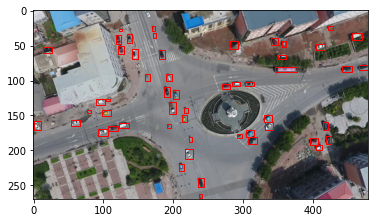

In [4]:
data_path = "/home/hu440/LP-MOT/LP-MOT/data/VisDrone"
visdrone_folders = [name for name in glob(os.path.join(data_path, '*'))]
train_csv = list()
val_csv = list()
test_csv = list()
for folder in visdrone_folders:
    for txt in glob(os.path.join(folder, 'annotations', '*')):
        if 'train' in folder:
            train_objs = open(txt).readlines()
            train_csv.append(txt)
        if 'val' in folder:
            val_objs = open(txt).readlines()
            val_csv.append(txt)
        if 'test' in folder:
            test_objs = open(txt).readlines()
            test_csv.append(txt)
# print(data_path)

# print(train_csv)

train_dataset = VisDroneDataset(
                        csv_files=train_csv,
                        root_dir=data_path+"/VisDrone2019-MOT-train", transform=transforms.Compose([Rescale((270, 480))]))#, ToTensor()]))
obj = train_dataset[0]
# obb1 = train_dataset[1008]
show_bbox(obj[0], obj[1])


In [28]:
# show_bbox(obj[0], obj[1])
# show_bbox(obb1[0], obb1[1])
obj

(tensor([[[0.7333, 0.7412, 0.7451,  ..., 0.7569, 0.7255, 0.7176],
          [0.7373, 0.7490, 0.7569,  ..., 0.7725, 0.7882, 0.8039],
          [0.7529, 0.7647, 0.7765,  ..., 0.7529, 0.7490, 0.7490],
          ...,
          [0.6353, 0.6157, 0.6078,  ..., 0.6314, 0.6235, 0.6196],
          [0.6431, 0.6235, 0.6157,  ..., 0.6471, 0.6196, 0.5961],
          [0.6471, 0.6314, 0.6275,  ..., 0.6549, 0.6118, 0.5686]],
 
         [[0.7137, 0.7216, 0.7255,  ..., 0.7451, 0.7137, 0.7059],
          [0.7176, 0.7294, 0.7373,  ..., 0.7608, 0.7765, 0.7922],
          [0.7333, 0.7451, 0.7569,  ..., 0.7412, 0.7373, 0.7373],
          ...,
          [0.6745, 0.6471, 0.6353,  ..., 0.6353, 0.6275, 0.6235],
          [0.6824, 0.6549, 0.6471,  ..., 0.6510, 0.6235, 0.6000],
          [0.6824, 0.6627, 0.6549,  ..., 0.6588, 0.6157, 0.5725]],
 
         [[0.7020, 0.7098, 0.7137,  ..., 0.7529, 0.7216, 0.7137],
          [0.7059, 0.7176, 0.7255,  ..., 0.7686, 0.7843, 0.8000],
          [0.7216, 0.7333, 0.7451,  ...,